In [1]:
import pandas as pd
import numpy as np
import requests as req
import datetime as dt
import time
from scipy.stats import norm, binom
import statsmodels.api as sm
import matplotlib.pyplot as plt

__Pet проект__. 

Данная тетрадь представляет из себя набор функций на основании которых можно составить стратегию для торгового бота

Представлены функции для загрузки данных с Московской биржи:
- Цены акции

Представлены функции для расчета:
- Симуляция портфеля из трех акций методом Монте Карло
- Симуляция портфеля из трех акций методом Монте Карло с учетом корреляции


# Загрузка данных

__Константы для функций__

In [2]:
# Определение констант 
SECID = 'SBER'
SECID_2 = 'YNDX'
SECID_3 = 'GAZP'
TICKERS = [SECID, SECID_2, SECID_3] 
NUM_SHARES = [10, 5, 20]  
END_DATE = dt.datetime.today().strftime('%Y-%m-%d') # Окно заканчивается сегодняшней ценой закрытия
START_DATE = (dt.datetime.today() - dt.timedelta(days=365)).strftime('%Y-%m-%d') #Окно начинается год назад

## Загрузка данных акций

Для загрузки данных с API применяются три основные функции:
__flatten__, __get_moex_stock_data__, __get_moex_data_and_prepare__

### Описание функций

__- flatten__ используется для преобразования вложенного JSON-объекта, полученного из MOEX API, в плоский список словарей.

- **Параметры**:
  - `j` (dict): JSON-объект, полученный из MOEX API. Этот объект должен содержать блок данных с определёнными столбцами и значениями.
  - `blockname` (str): Имя ключа в JSON-объекте, который содержит необходимые данные. Обычно этот ключ указывает на блок данных, например, “history”.

__- get_moex_stock_data__ - возвращает список словарей, где каждый словарь представляет одну запись с данными о ценах акций.

- **Параметры**:
  - `secid` (str): Идентификатор ценной бумаги.
  - `start_date` (str или datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
  - `end_date` (str или datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.
  - `engine` (str): Движок рынка. По умолчанию 'stock'.
  - `market` (str): Рынок. По умолчанию 'shares'.
  - `board` (str): Торговая площадка. По умолчанию 'TQBR'.

__- get_moex_data_and_prepare__ - извлекает данные о ценах акций с MOEX API за заданный период времени.

- **Параметры**:
  - `secid` (str): Идентификатор ценной бумаги.
  - `start_date` (str или datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
  - `end_date` (str или datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.

- **Функция** использует __get_moex_stock_data__ для получения данных и преобразует их в DataFrame с ценами акций и доходностью.

### Функции

In [3]:
# Функция для извлечения данных с JSON объекта
def flatten(j: dict, blockname: str):
    columns = j[blockname]['columns']
    return [{k: r[I] for I, k in enumerate(columns)} for r in j[blockname]['data']]

# Функция для запроса тикера и извлечения данных с JSON объекта
def get_moex_stock_data(secid, start_date, end_date, engine='stock', market='shares', board='TQBR'):
    if isinstance(start_date, str):
        start_date = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
    if isinstance(end_date, str):
        end_date = dt.datetime.strptime(end_date, "%Y-%m-%d").date()

    all_data = []
    current_start_date = start_date

    while current_start_date <= end_date:
        current_end_date = current_start_date + dt.timedelta(days=99)
        if current_end_date > end_date:
            current_end_date = end_date

        url = f"https://iss.moex.com/iss/history/engines/{engine}/markets/{market}/boards/{board}/securities/{secid}.json?from={current_start_date}&till={current_end_date}&iss.meta=off"
        try:
            r = req.get(url)
            r.encoding = 'utf-8'
            j = r.json()

            flattened_data = flatten(j, 'history')
            all_data.extend(flattened_data)

            current_start_date = current_end_date + dt.timedelta(days=1)

            time.sleep(1)

        except req.exceptions.RequestException as e:
            print(f"Запрос не удался: {e}")
            break

    return all_data

# Функция для обработки данных и упрощения данных
def get_moex_data_and_prepare(secid, start_date, end_date):
    data = get_moex_stock_data(secid, start_date, end_date)
    df = pd.DataFrame(data)
    df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
    df.set_index('TRADEDATE', inplace=True)
    df = df[['CLOSE']].asfreq("B").fillna(method='ffill')
    df.columns = [f'{secid}_Stock_Price']
    
    df[f'{secid}_Daily_Return'] = df[f'{secid}_Stock_Price'].pct_change()
    df.dropna(inplace=True)
    
    return df

### Пример использования

In [4]:
ticker_df = get_moex_data_and_prepare(SECID, START_DATE, END_DATE)

In [5]:
display(ticker_df.tail(10))
display(ticker_df.describe().T)
mean_ticker_return = round(ticker_df[f'{SECID}_Daily_Return'].mean(), 3)
print(f'Средняя доходность {SECID}:{mean_ticker_return}')

,SBER_Stock_Price,SBER_Daily_Return
TRADEDATE,,
2024-05-29,320.38,0.006788
2024-05-30,316.63,-0.011705
2024-05-31,313.11,-0.011117
2024-06-03,310.95,-0.006899
2024-06-04,316.49,0.017816
2024-06-05,314.72,-0.005593
2024-06-06,313.08,-0.005211
2024-06-07,319.90,0.021784
2024-06-10,317.28,-0.008190


,count,mean,std,min,25%,50%,75%,max
SBER_Stock_Price,260.0,277.649346,22.666438,235.670000,261.062500,273.870000,295.672500,323.540000
SBER_Daily_Return,260.0,0.001071,0.010996,-0.043058,-0.004693,0.000691,0.005449,0.072818


Средняя доходность SBER:0.001


# Симуляции портфеля методом Монте-Карло

## Описание функций для симуляции портфеля методом Монте-Карло

- **portfolio_value**
  - **Задача**: Рассчитать стоимость портфеля на основе доходностей и количества акций.
  - **Параметры**:
    - `returns`: Датафрейм с доходностями акций.
    - `num_shares`: Список с количеством акций каждого типа.
  - **Возвращает**: Стоимость портфеля.

- **calculate_initial_portfolio_value**
  - **Задача**: Рассчитать начальную стоимость портфеля.
  - **Параметры**:
    - `start_prices`: Начальные цены акций.
    - `num_shares`: Список с количеством акций каждого типа.
  - **Возвращает**: Начальную стоимость портфеля.

- **simulate_portfolio**
  - **Задача**: Симулировать доходности портфеля без учета корреляции.
  - **Параметры**:
    - `returns`: Датафрейм с доходностями акций.
    - `num_shares`: Список с количеством акций каждого типа.
    - `start_prices`: Начальные цены акций.
    - `num_simulations`: Количество симуляций.
    - `num_days`: Количество дней симуляции.
  - **Возвращает**: Массив результатов симуляций.

- **correlated_simulations**
  - **Задача**: Симулировать доходности портфеля с учетом корреляции.
  - **Параметры**: 
    - `returns`: Датафрейм с доходностями акций.
    - `num_shares`: Список с количеством акций каждого типа.
    - `start_prices`: Начальные цены акций.
    - `num_simulations`: Количество симуляций.
    - `num_days`: Количество дней симуляции.
  - **Возвращает**: Массив результатов симуляций.

- **get_simulation_results**
  - **Задача**: Получить данные, провести симуляции и рассчитать метрики.
  - **Параметры**:
    - `tickers`: Список тикеров акций.
    - `num_shares`: Список с количеством акций каждого типа.
    - `start_date`: Дата начала периода.
    - `end_date`: Дата конца периода.
    - `num_simulations`: Количество симуляций.
    - `num_days`: Количество дней симуляции.
  - **Возвращает**: Датафрейм с результатами симуляций и массивы результатов симуляций.

- **apply_simulation_results_to_portfolio**
  - **Задача**: Применить результаты симуляции к стоимости портфеля.
  - **Параметры**:
    - `df_sim`: Датафрейм с результатами симуляций.
    - `initial_portfolio_value`: Начальная стоимость портфеля.
  - **Возвращает**: Датафрейм с прогнозируемой стоимостью портфеля.

- **plot_simulation_results**
  - **Задача**: Визуализировать результаты симуляции.
  - **Параметры**:
    - `df_sim`: Датафрейм с результатами симуляций.

- **plot_portfolio_value_simulation_results**
  - **Задача**: Визуализировать стоимость портфеля.
  - **Параметры**:
    - `df_sim_value`: Датафрейм с прогнозируемой стоимостью портфеля.

# Функции

In [23]:
# Функция для учета количества акций в портфеле
def portfolio_value(returns, num_shares):
    return (returns * num_shares).sum(axis=1)

# Функция для расчета начальной стоимости портфеля
def calculate_initial_portfolio_value(start_prices, num_shares):
    return np.sum(start_prices * num_shares)

# Функция для симуляции портфеля без корреляции с использованием нормального распределения
def simulate_portfolio(returns, num_shares, start_prices, num_simulations=1000, num_days=30):
    results = np.zeros((num_simulations, num_days))
    
    # Расчет стандартных отклонений за последние 90 дней
    std_returns = returns.rolling(window=90).std().iloc[-1]
    
    for I in range(num_simulations):
        # Генерация случайных доходностей из нормального распределения с нулевым средним
        daily_returns = np.random.normal(0, std_returns, (num_days, len(returns.columns)))
        daily_returns = pd.DataFrame(daily_returns, columns=returns.columns)
        
        # Расчет доходности портфеля
        portfolio_returns = portfolio_value(daily_returns, num_shares)
        
        # Расчет кумулятивной доходности
        cum_returns = np.cumprod(1 + portfolio_returns.values) - 1
        results[I, :] = cum_returns
   
    return results

# Функция для симуляции портфеля с корреляцией с использованием нормального распределения
def correlated_simulations(returns, num_shares, start_prices, num_simulations=1000, num_days=30):
    # Расчет средних значений и ковариационной матрицы за последние 90 дней
    recent_returns = returns[-90:]
    mean_returns = np.zeros(len(returns.columns))  # Нулевое среднее
    cov_matrix = recent_returns.cov().values
    
    results = np.zeros((num_simulations, num_days))
    
    for I in range(num_simulations):
        correlated_randomness = np.random.multivariate_normal(mean_returns, cov_matrix, num_days)
        daily_returns = pd.DataFrame(correlated_randomness, columns=returns.columns)
        portfolio_returns = portfolio_value(daily_returns, num_shares)
        cum_returns = np.cumprod(1 + portfolio_returns.values) - 1
        results[I, :] = cum_returns
    
    return results

# Функция для получения данных, проведения симуляций и расчетов
def get_simulation_results(tickers, num_shares, start_date, end_date, num_simulations=1000, num_days=10):
    dataframes = [get_moex_data_and_prepare(ticker, start_date, end_date) for ticker in tickers]
    returns = pd.concat([df[f'{ticker}_Daily_Return'] for df, ticker in zip(dataframes, tickers)], axis=1)
    start_prices = pd.concat([df[f'{ticker}_Stock_Price'].iloc[-1:] for df, ticker in zip(dataframes, tickers)], axis=1).values.flatten()

    returns.dropna(inplace=True)

    sim_results = simulate_portfolio(returns, num_shares, start_prices, num_simulations, num_days)
    corr_sim_results = correlated_simulations(returns, num_shares, start_prices, num_simulations, num_days)

    # Расчет статистических метрик
    mean_sim = np.mean(sim_results, axis=0)
    std_sim = np.std(sim_results, axis=0)
    conf_int_sim = np.percentile(sim_results, [2.5, 97.5], axis=0)

    mean_corr_sim = np.mean(corr_sim_results, axis=0)
    std_corr_sim = np.std(corr_sim_results, axis=0)
    conf_int_corr_sim = np.percentile(corr_sim_results, [2.5, 97.5], axis=0)

    # Создание датафрейма для отображения прогнозов
    days = np.arange(1, num_days + 1)
    df_sim = pd.DataFrame({
        'Day': days,
        'Mean (Uncorrelated)': mean_sim,
        'Std (Uncorrelated)': std_sim,
        'Mean (Correlated)': mean_corr_sim,
        'Std (Correlated)': std_corr_sim,
    })

    return df_sim, sim_results, corr_sim_results

# Функция для применения результатов симуляции к стоимости портфеля
def apply_simulation_results_to_portfolio(df_sim, initial_portfolio_value):
    df_sim_value = df_sim.copy()
    
    # Применяем начальную стоимость портфеля к каждому столбцу с результатами симуляций
    df_sim_value['Portfolio Value (Uncorrelated)'] = initial_portfolio_value * (1 + df_sim['Mean (Uncorrelated)'])  
    df_sim_value['Portfolio Value (Correlated)'] = initial_portfolio_value * (1 + df_sim['Mean (Correlated)'])

    return df_sim_value
    
# Функция для визуализации результатов симуляции
def plot_simulation_results(df_sim):
    plt.figure(figsize=(10, 5))
    plt.plot(df_sim['Day'], df_sim['Mean (Uncorrelated)'], label='Средний (без корреляции)', color='blue')
    plt.plot(df_sim['Day'], df_sim['Mean (Correlated)'], label='Средний (с корреляцией)', color='red')

    plt.title('Усредненные прогнозы Монте-Карло симуляций с доверительными интервалами')
    plt.xlabel('Дни')
    plt.ylabel('Средняя кумулятивная доходность (%)')
    plt.legend()
    plt.show()

# Функция для визуализации стоимости портфеля
def plot_portfolio_value_simulation_results(df_sim_value):
    plt.figure(figsize=(10, 5))
    plt.plot(df_sim_value['Day'], df_sim_value['Portfolio Value (Uncorrelated)'], label='Средняя стоимость портфеля (без корреляции)', color='blue')
  
    plt.plot(df_sim_value['Day'], df_sim_value['Portfolio Value (Correlated)'], label='Средняя стоимость портфеля (с корреляцией)', color='red')
   
    plt.title('Прогноз стоимости портфеля Монте-Карло с доверительными интервалами')
    plt.xlabel('Дни')
    plt.ylabel('Стоимость портфеля')
    plt.legend()
    plt.show()

## Пример использования

In [24]:
dataframes = [get_moex_data_and_prepare(ticker, START_DATE, END_DATE) for ticker in TICKERS]
start_prices = np.array([df[f'{ticker}_Stock_Price'].iloc[-1] for df, ticker in zip(dataframes, TICKERS)])
initial_portfolio_value = calculate_initial_portfolio_value(start_prices, NUM_SHARES)
df_sim, sim_results, corr_sim_results = get_simulation_results(TICKERS, NUM_SHARES, START_DATE, END_DATE)
df_sim_value = apply_simulation_results_to_portfolio(df_sim, initial_portfolio_value)

Стоимость портфеля на 2024-06-12: 26038.6 


,Day,Mean (Uncorrelated),Std (Uncorrelated),Mean (Correlated),Std (Correlated),Portfolio Value (Uncorrelated),Portfolio Value (Correlated)
0,1,0.017628,0.301297,0.004967,0.348123,26497.612615,26167.928131
1,2,0.020967,0.443256,-0.028878,0.487926,26584.543237,25286.669111
2,3,0.014008,0.545120,-0.035149,0.604280,26403.358931,25123.375500
3,4,0.029805,0.666027,-0.024706,0.743301,26814.692444,25395.287670
4,5,0.049014,0.805925,-0.019795,0.863204,27314.847559,25523.173929
5,6,0.039389,0.879042,-0.003732,1.012479,27064.241806,25941.431893
6,7,0.042886,0.979739,0.005346,1.190268,27155.281038,26177.804316
7,8,0.032863,0.988434,-0.003250,1.324587,26894.308363,25953.961928
8,9,0.028008,1.081018,-0.002945,1.493437,26767.901575,25961.905884
9,10,0.011097,1.136683,-0.013804,1.604649,26327.557879,25679.165937


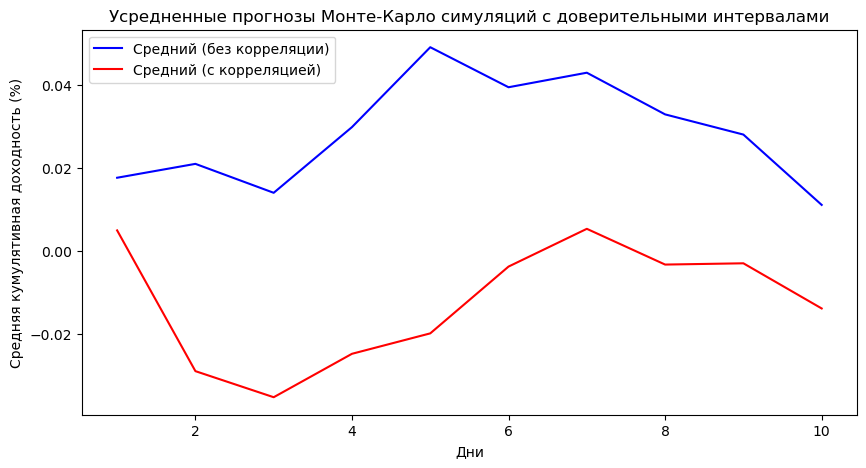

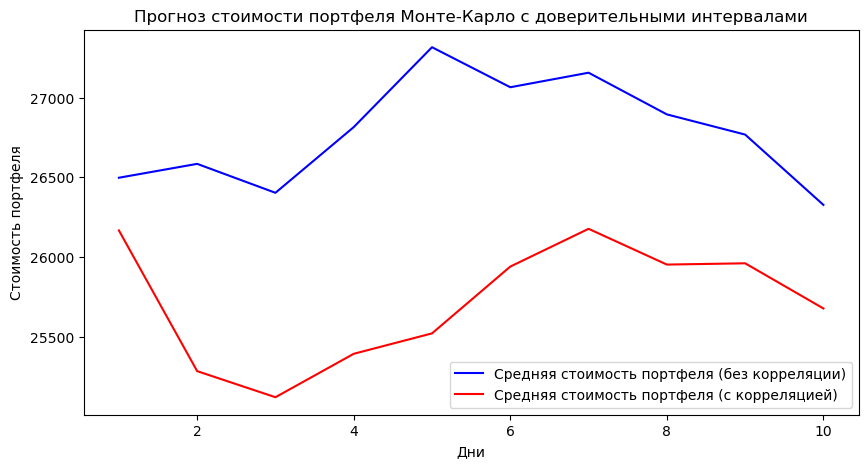

In [29]:
print(f'Стоимость портфеля на {END_DATE}: {initial_portfolio_value} ')
display(df_sim_value)
plot_simulation_results(df_sim)
plot_portfolio_value_simulation_results(df_sim_value)